In [1]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pkl
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# reuse  https://github.com/arnaldog12/Deep-Learning/blob/master/problems/Regressor-Face%20Pose/Keras.ipynb approach

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip -uq "/content/drive/My Drive/datasets/pose.zip" -d "/content/drive/My Drive/datasets"

In [4]:
images, labels = pkl.load(open('/content/drive/My Drive/datasets/pose/samples.pkl', 'rb'))

print(images.shape, labels.shape)

(6288, 2278) (6288, 3)


In [5]:
labels

array([[  0.5956949 ,   3.03410077,  -4.09082985],
       [  0.74340367,  -3.66810846,   1.15535188],
       [  3.00473642,  -8.58637238,  -6.46797752],
       ...,
       [ 43.00866699, -18.92081451,  12.54327679],
       [ -0.61782241,   0.40333369,  -7.63538599],
       [ -4.95394087, -15.05262184, -43.25955963]])

In [6]:
labels[0]

array([ 0.5956949 ,  3.03410077, -4.09082985])

In [7]:
images

array([[ 32.06243896,  62.28964615,  93.53608704, ...,  13.15294647,
         26.        ,  13.15294647],
       [ 37.01351166,  75.32595825, 111.87940216, ...,  15.29705811,
         29.01723671,  14.14213562],
       [ 38.        ,  77.10382843, 115.27792358, ...,  16.03121948,
         31.06444931,  15.29705811],
       ...,
       [ 39.44616699,  79.62411499, 118.47362518, ...,  18.02775574,
         35.34119415,  17.49285507],
       [ 11.        ,  22.02271461,  33.06055069, ...,   5.        ,
         10.        ,   5.        ],
       [ 20.61552811,  42.42640686,  65.03076172, ...,   9.48683262,
         16.55294609,   7.21110249]])

In [8]:
len(images[0])

2278

In [9]:
roll, pitch, yaw = labels[:, 0], labels[:, 1], labels[:, 2]

In [10]:
print(roll.min(), roll.max(), roll.mean(), roll.std())
print(pitch.min(), pitch.max(), pitch.mean(), pitch.std())
print(yaw.min(), yaw.max(), yaw.mean(), yaw.std())

-46.06486893 43.00866699 -0.52579503197042 5.176231116713095
-29.88856888 34.09674835 2.584682740273537 7.962828151857226
-75.55059814 86.84925079 -0.11620588007315523 13.090839183150852


In [11]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=101)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.6, random_state=101)

In [12]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(4401, 2278) (4401, 3)
(754, 2278) (754, 3)
(1133, 2278) (1133, 3)


In [13]:
std = StandardScaler()
std.fit(x_train)
x_train = std.transform(x_train)
x_val = std.transform(x_val)
x_test = std.transform(x_test)

## Model hyperparameters

In [14]:
# set batch size and epoch
EPOCHS = 4
BATCH_SIZE = 16

In [15]:
images.shape[1]

2278

In [16]:
from keras.engine.base_layer import Layer
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from tensorflow.keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
import tensorflow.keras.backend as K

class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(x):
    return x*K.tanh(K.softplus(x))

get_custom_objects().update({'Mish': Mish(mish)})

In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1024, activation='relu', kernel_regularizer='l2', input_dim=images.shape[1]))
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer='l2'))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=3, activation='linear'))

callback_list = [EarlyStopping(monitor='val_loss', patience=25)]

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'] )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              2333696   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 195       
Total params: 3,006,467
Trainable params: 3,006,467
Non-trainable params: 0
_________________________________________________________________


In [18]:
hist = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callback_list)

Epoch 1/4
276/276 [==============================] - 1s 4ms/step - loss: 70.1518 - accuracy: 0.6149 - val_loss: 52.9600 - val_accuracy: 0.6260
Epoch 2/4
276/276 [==============================] - 1s 3ms/step - loss: 53.7471 - accuracy: 0.6744 - val_loss: 47.0300 - val_accuracy: 0.6830
Epoch 3/4
276/276 [==============================] - 1s 3ms/step - loss: 48.9281 - accuracy: 0.6894 - val_loss: 45.6664 - val_accuracy: 0.7029
Epoch 4/4
276/276 [==============================] - 1s 3ms/step - loss: 47.6059 - accuracy: 0.6969 - val_loss: 40.6154 - val_accuracy: 0.7135


In [19]:
model.save('/content/drive/My Drive/models/head_pose_model.h5')

In [20]:
Train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss: ', Train_score[0])
print('Train accuracy: ', Train_score[1])

Val_score = model.evaluate(x_val, y_val, verbose=0)
print('Val loss: ', Val_score[0])
print('Val accuracy: ', Val_score[1])

Test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: ', Test_score[0])
print('Test accuracy: ', Test_score[1])

Train loss:  44.687660217285156
Train accuracy:  0.7046126127243042
Val loss:  40.6153564453125
Val accuracy:  0.7135278582572937
Test loss:  42.04755783081055
Test accuracy:  0.6875551342964172


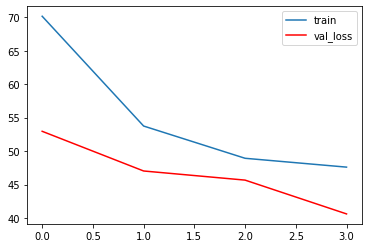

In [21]:
history = hist.history
loss_train = history['loss']
loss_val = history['val_loss']

plt.figure()
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='val_loss', color='red')
plt.legend()
plt.savefig('/content/drive/My Drive/reports/train_val_head_pose.png')

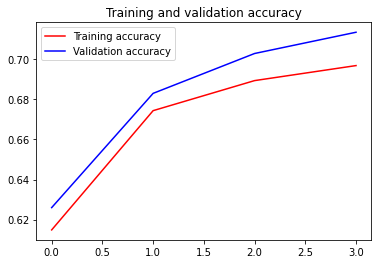

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [22]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
#prec = histories.history['precision']
#val_prec = histories.history['val_precision']
#recall = histories.history['recall']
#val_recall = histories.history['val_recall']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()
plt.savefig("/content/drive/My Drive/head_train_val_acc_200_epochs_batch_64.png")

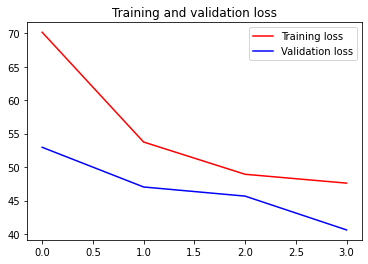

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [23]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()
plt.savefig("/content/drive/My Drive/reports/head_train_val_loss_100_epochs_batch_64.png")

In [24]:
hist.history

{'accuracy': [0.6148602366447449,
  0.6743921637535095,
  0.6893887519836426,
  0.6968870759010315],
 'loss': [70.15180206298828,
  53.7470703125,
  48.92814636230469,
  47.60594177246094],
 'val_accuracy': [0.6259946823120117,
  0.6830238699913025,
  0.702917754650116,
  0.7135278582572937],
 'val_loss': [52.96001052856445,
  47.029964447021484,
  45.666404724121094,
  40.615352630615234]}

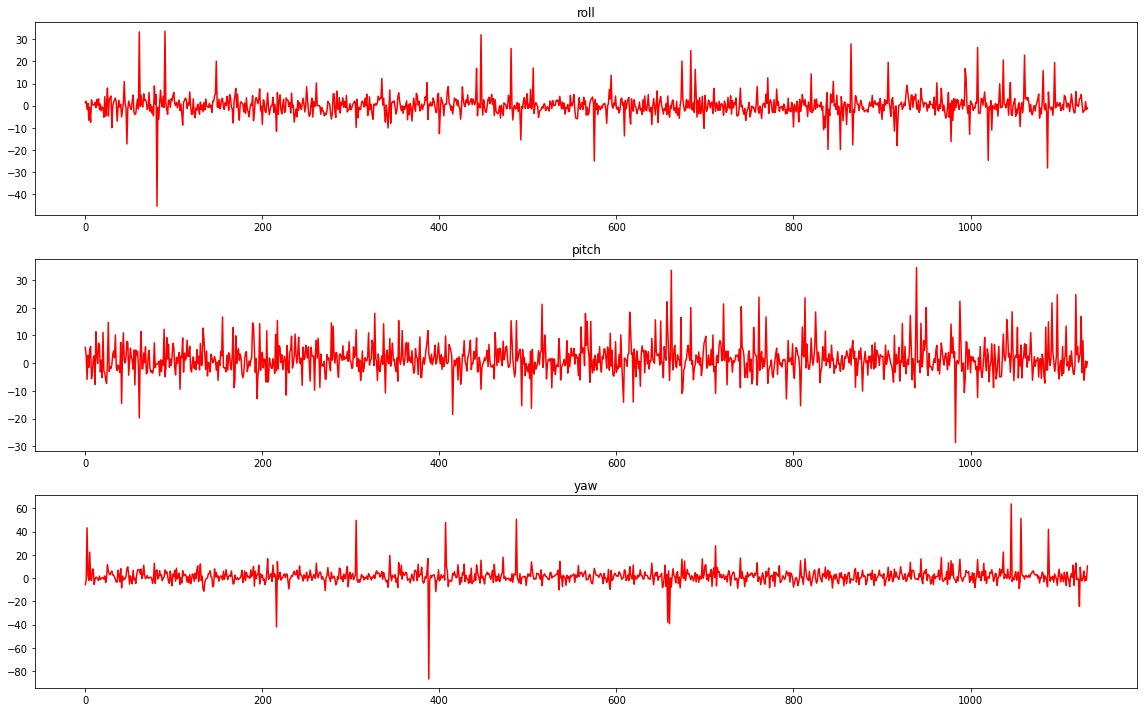

In [25]:
y_pred = model.predict(x_test)
diff = y_test - y_pred
diff_roll = diff[:, 0]
diff_pitch = diff[:, 1]
diff_yaw = diff[:, 2]

plt.figure(figsize=(16, 10))

plt.subplot(3, 1, 1)
plt.plot(diff_roll, color='red')
plt.title('roll')

plt.subplot(3, 1, 2)
plt.plot(diff_pitch, color='red')
plt.title('pitch')

plt.subplot(3, 1, 3)
plt.plot(diff_yaw, color='red')
plt.title('yaw')

plt.tight_layout()
plt.savefig("/content/drive/My Drive/reports/roll_picth_yaw_pred.png")

## Testing Model

In [26]:

def detect_face_points(image):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("/content/drive/My Drive/shape_predictor_68_face_landmarks.dat")
    face_rect = detector(image, 1)
    if len(face_rect) != 1: return []
    
    dlib_points = predictor(image, face_rect[0])
    face_points = []
    for i in range(68):
        x, y = dlib_points.part(i).x, dlib_points.part(i).y
        face_points.append(np.array([x, y]))
    return face_points
        
def compute_features(face_points):
    assert (len(face_points) == 68), "len(face_points) must be 68"
    
    face_points = np.array(face_points)
    features = []
    for i in range(68):
        for j in range(i+1, 68):
            features.append(np.linalg.norm(face_points[i]-face_points[j]))
            
    return np.array(features).reshape(1, -1)

In [27]:
def test(path = '/content/drive/My Drive/datasets/lena_std.tif'):
  im = cv2.imread(path, cv2.IMREAD_COLOR)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  face_points = detect_face_points(im)

  for x, y in face_points:
      cv2.circle(im, (x, y), 1, (0, 255, 0), -1)
      
  features = compute_features(face_points)
  features = std.transform(features)

  model = tf.keras.models.load_model('/content/drive/My Drive/models/head_pose_model.h5')
  y_pred = model.predict(features)

  roll_pred, pitch_pred, yaw_pred = y_pred[0]
  print(' Roll: {:.2f}°'.format(roll_pred))
  print('Pitch: {:.2f}°'.format(pitch_pred))
  print('  Yaw: {:.2f}°'.format(yaw_pred))
      
  plt.figure(figsize=(10, 10))
  plt.imshow(im)

 Roll: 1.40°
Pitch: -2.50°
  Yaw: 12.18°


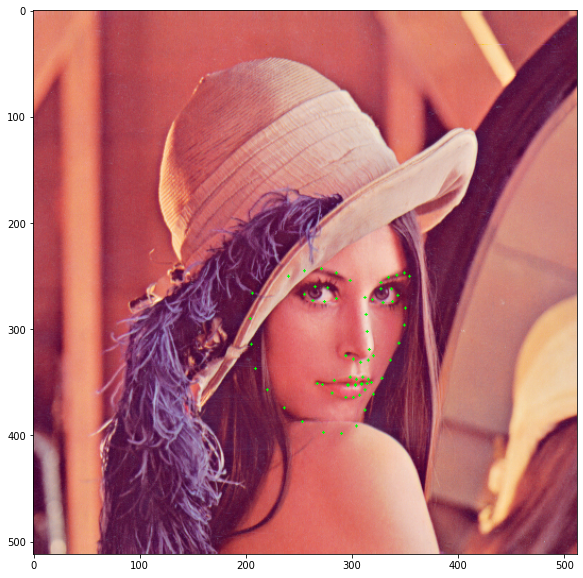

In [28]:
test()

In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
y_pred = model.predict(x_test)

In [31]:
y_pred

array([[-1.5758581 , -4.367344  ,  2.8648443 ],
       [-0.24726517,  4.745134  , -2.231702  ],
       [-0.09187408,  2.7241154 , 15.451607  ],
       ...,
       [-0.86150366,  4.57315   , -2.3230927 ],
       [ 0.6596838 , -6.9261813 ,  0.47794515],
       [ 2.3301144 , -7.476748  ,  3.7625444 ]], dtype=float32)

In [32]:
# build corresponding predict label
def match_pred_label(y_pred):
   pred = []

   # index
   indice_max = -1
   for pred_res in y_pred:
     pred_max = max(pred_res)
     for i in range(len(pred_res)):
       if pred_res[i] == pred_max:
         pred.append(i)
    
   return pred


In [33]:
pred = match_pred_label(y_pred)

In [34]:
pred

[2,
 1,
 2,
 2,
 0,
 1,
 0,
 2,
 2,
 0,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 2,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 2,
 2,
 0,
 1,
 1,
 0,
 2,
 1,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 2,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 0,
 0,
 2,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 2,
 2,
 1,
 1,
 0,
 0,
 0,
 1,
 2,
 0,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 0,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 0,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 0,
 2,
 0,
 0,
 1,
 0,
 2,
 1,
 2,
 0,
 1,
 1,
 0,
 0,
 1,
 2,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 0,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 0,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 2,
 0,
 2,
 2,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 2,
 0,
 2,
 1,


In [35]:
y = match_pred_label(y_test)

In [36]:
y

[1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 2,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 0,
 2,
 0,
 2,
 0,
 1,
 0,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 0,
 1,
 2,
 1,
 1,
 2,
 2,
 0,
 1,
 1,
 2,
 2,
 0,
 2,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 0,
 2,
 2,
 0,
 0,
 1,
 1,
 2,
 0,
 0,
 2,
 2,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 2,
 1,
 1,
 1,
 1,
 0,
 2,
 2,
 0,
 0,
 1,
 2,
 0,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 0,
 2,
 0,
 0,
 1,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 0,
 0,
 2,
 2,
 1,
 1,
 2,
 0,
 2,
 1,
 2,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 0,
 1,
 1,
 1,
 2,
 2,
 0,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 0,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 0,
 1,
 1,


In [37]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y, pred)
print(cf_matrix)

[[117  50  36]
 [ 64 452  76]
 [ 70  58 210]]


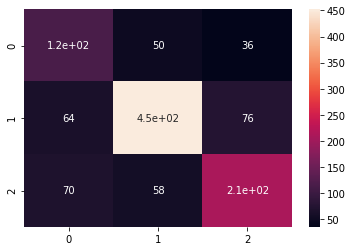

In [38]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [39]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

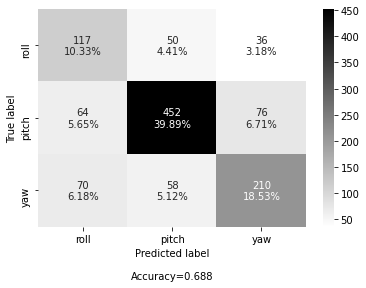

In [40]:
_labels = ['True Neg','False Pos','False Neg','True Pos']
make_confusion_matrix(cf_matrix, group_names=_labels,categories=('roll', 'pitch', 'yaw' ), cmap='binary')

In [41]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y, pred, target_names=('roll', 'pitch', 'yaw' )))


Classification Report

              precision    recall  f1-score   support

        roll       0.47      0.58      0.52       203
       pitch       0.81      0.76      0.78       592
         yaw       0.65      0.62      0.64       338

    accuracy                           0.69      1133
   macro avg       0.64      0.65      0.65      1133
weighted avg       0.70      0.69      0.69      1133

